This notebook will create sets of potentials to run simulations with.

## Importing Libraries

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import MagicTools as mt
import itertools as it
from scipy.signal import savgol_filter
import string

## Creating the Potentials

Each potential will be a numpy array consisting of 300 points.

In order to be physical, for short distances (small r) the value of the potential needs to be very high (forbidden region), and need to go to zero for large r.

In [2]:
random.seed(1)

In [4]:
def getforbid():
    forbid = random.gauss(75, 30)
    forbid = int(round(forbid, 0))
    if forbid > 0 and forbid < 300:
        return forbid
    else:
        return getforbid()
        
#this function generates the size of the forbidden reason randomly, according to a gaussian distribution
#centred at 75
#with s.d. 30 (cannot be negative)
#this will determine how many of the 300 entries in the potential make up the forbidden region

0.0


(-30.0, 30.0)

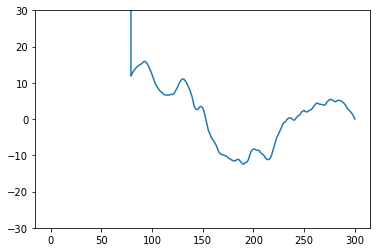

In [44]:
pot = np.zeros(300)
forbid = getforbid()
for i in range(forbid):
    pot[i] = 75000 - 50*i

non_forbid = np.zeros(300 - forbid)
non_forbid[0] = random.gauss(0, 3.5)
i = 1
while i < len(non_forbid):
    non_forbid[i] = non_forbid[i - 1] + random.random() * random.gauss(0, 2)
    i = i + 1

non_forbid_smooth = savgol_filter(non_forbid, 15, 3)

for i in range(len(non_forbid_smooth)):
    pot[forbid + i] = non_forbid_smooth[i]

shift = pot[len(pot) - 1]
pot = pot - shift

#smooth = savgol_filter(pot, 15, 2)

print(pot[299])

x = np.linspace(0,300, 300)
plt.plot(x, pot)
#plt.plot(x, smooth, color = 'red')
plt.ylim(-30,30)

(-30.0, 30.0)

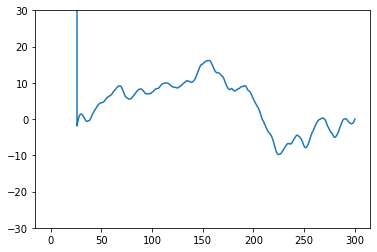

In [53]:
plt.plot(x, create_potential(300))
plt.ylim(-30,30)

In [46]:
def create_potential(N):
    pot = np.zeros(N)
    forbid = getforbid()
    for i in range(forbid):
        pot[i] = 75000 - 50*i

    non_forbid = np.zeros(N - forbid)
    non_forbid[0] = random.gauss(0, 3.5)
    i = 1
    while i < len(non_forbid):
        non_forbid[i] = non_forbid[i - 1] + random.random() * random.gauss(0, 2)
        i = i + 1

    non_forbid_smooth = savgol_filter(non_forbid, 15, 3)

    for i in range(len(non_forbid_smooth)):
        pot[forbid + i] = non_forbid_smooth[i]

    shift = pot[len(pot) - 1]
    pot = pot - shift
    
    return pot

In [54]:
potentials = []
while len(potentials) < 10000:
    pot = create_potential(300)
    potentials.append(pot)
    
#potentials is a list where each object in the list is a numpy array containing 300 values representing a potential

## Writing Potentials to LAMMPS Files

Using MagicTools:

First write potentials to MagicTools .pot files

In [121]:
N = int(2) #N is number of bead types
N_NB = int(N*(N+1)/2) #number of non-bonded interactions
N_B = int(0) #number of bonded interactions
N_A = int(0) #number of angle interactions

Min = 0  
Max = 15 #range of r for potentials

NPoints = int(300) #Number of points in each potential

stepsize = (Max-Min)/NPoints #the distance between points
rvalues = np.linspace(Min + stepsize/2, Max - stepsize/2, NPoints) #an array containg the r values

AtomList = ['A', 'B'] #the atom types
AtomPairs = list(it.combinations_with_replacement(AtomList, r = 2)) #all possible atoms pairs, no repeats

In [109]:
general_section = " &General \n" + " NTypes= {} \n".format(N) + " N_NB= {} \n".format(N_NB) + \
" N_B= {} \n".format(N_B) + " N_A= {} \n".format(N_A)+ " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + \
" NPoints= {} \n".format(NPoints) + " &EndGeneral"

In [119]:
potential_section = ''
for i in range(len(AtomPairs)):
    single_pot = potentials[random.randint(0, len(potentials)-1)]
    header_section = " &Potential \n" + " Name= {}-{} \n".format(AtomPairs[i][0], AtomPairs[i][1]) + " Type = NB \n" \
    + " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + " NPoints= {} \n".format(NPoints) + \
    " AtomTypes= {},{} \n".format(AtomPairs[i][0], AtomPairs[i][1])
    table_section = ' &Table \n'
    for j in range(NPoints):
        rval = format(rvalues[j], '.7f')
        potval = format(single_pot[j], '.7f')
        table_section = table_section + "     " + str(rval) + "  " + str(potval) + " \n"
    table_section = table_section + " &EndTable \n" + " &EndPotential \n"
    potential_section = potential_section + table_section

In [120]:
potfile = open('potential.pot', 'w')
potfile.write(general_section)
potfile.write(potential_section)
potfile.close()

In [66]:
alphabet_list = list(string.ascii_uppercase)
all_atoms_seperate = list(it.product(alphabet_list, repeat = 2))
all_atoms = []
for i in range(len(all_atoms_seperate)):
    atom = all_atoms_seperate[i][0] + all_atoms_seperate[i][1]
    all_atoms.append(atom)

In [76]:
def write_potential(filename, N):
    N = int(N)
    N_NB = int(N*(N+1)/2) #number of non-bonded interactions
    N_B = int(0) #number of bonded interactions
    N_A = int(0) #number of angle interactions

    Min = 0  
    Max = 15 #range of r for potentials

    NPoints = int(300) #Number of points in each potential

    stepsize = (Max-Min)/NPoints #the distance between points
    rvalues = np.linspace(Min + stepsize/2, Max - stepsize/2, NPoints) #an array containg the r values

    AtomList = []
    for i in range(N):
        AtomList.append(all_atoms[i])
        
    AtomPairs = list(it.combinations_with_replacement(AtomList, r = 2)) #all possible atoms pairs, no repeats
    
    
    
    general_section = " &General \n" + " NTypes= {} \n".format(N) + " N_NB= {} \n".format(N_NB) + \
    " N_B= {} \n".format(N_B) + " N_A= {} \n".format(N_A)+ " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + \
    " NPoints= {} \n".format(NPoints) + " &EndGeneral \n"
    
    potential_section = ''
    for i in range(len(AtomPairs)):
        single_pot = potentials[random.randint(0, len(potentials)-1)]
        header_section = " &Potential \n" + " Name= {}-{} \n".format(AtomPairs[i][0], AtomPairs[i][1]) + " Type = NB \n" \
        + " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + " NPoints= {} \n".format(NPoints) + \
        " AtomTypes= {},{} \n".format(AtomPairs[i][0], AtomPairs[i][1])
        
        table_section = ' &Table \n'
        for j in range(NPoints):
            rval = format(rvalues[j], '.7f')
            potval = format(single_pot[j], '.7f')
            table_section = table_section + "     " + str(rval) + "  " + str(potval) + " \n"
        table_section = table_section + " &EndTable \n" + " &EndPotential \n"
        
        potential_section = potential_section + header_section + table_section
        
    potfile = open('{}.pot'.format(filename), 'w')
    potfile.write(general_section)
    potfile.write(potential_section)
    potfile.close()

In [90]:
for BeadNumber in range(1, 11):
    for j in range(10):
        write_potential('MagiC_Potentials/{}beadpotential{}'.format(BeadNumber, j), BeadNumber)
        pot = mt.ReadPot('MagiC_Potentials/{}beadpotential{}.pot'.format(BeadNumber, j), quiet = True)
        mt.PotsExport(sample_pot, MDEngine = 'LAMMPS', Rmaxtable = 25.0, PHImaxtable = 180.0, \
                      npoints = 2500, Umax = 6000.0, \
                      interpol = True, method = 'gauss', sigma = 0.5, noplot=True, hardcopy = False, \
                      filename = 'LAMMPS_Potentials/{}beadpotential{}'.format(BeadNumber, j))

Convert from Magic potential files to LAMMPS potential files

In [88]:
sample_pot = write_potential('samplepot', 3)
sample_pot = mt.ReadPot('samplepot.pot', quiet = True)
mt.PotsExport(sample_pot, MDEngine = 'LAMMPS', Rmaxtable = 25.0, PHImaxtable = 180.0, npoints = 2500, Umax = 6000.0, \
              interpol = True, method = 'gauss', sigma = 0.5, noplot=True, hardcopy = False, \
              filename = 'LAMMPS_Potentials/LAMMPSsample')